# Tutorial
In this notebook the basic usage of this package is explained.
Let us start by importing the needed libraries and defining our example system
$$ x_k = A x_{k-1} + w_k,$$
where $x_k\in \mathbb{R}^n$ is the system state, $A$ denotes the system matrix and $w_k\in \mathbb{R}^n$ is the process noise, assumed white and Gaussian, i.e. $w_k \sim \mathcal{N}(0, Q)$.

In [1]:
import numpy as np
from system_param import SystemParam

A = np.array([[0.9]])
Q = np.array([[1]])
x0 = np.array([1])  # initial state

params = SystemParam(A, Q, x0=x0)  # container that holds information about the system parameters
# The optimal encoding matrix L for the state-secrecy codes is automatically computed
print(params.L)

[[1.11111111]]


Now we initialize the legitimate user and the eavesdropper, which are instances of the class Estimator. Both have access to the system parameters A, Q, and L.

In [2]:
from estimator import Estimator

user = Estimator(params)
eavesdropper = Estimator(params)

Moreover, we initialize the sensor, which will send state information to the user according to its transmission strategy. Let us begin by employing the random transmission policy. For that, we use the RandomSensor class.

In [3]:
from sensor import RandomSensor

alpha = 0.2  # probability to send the plain state instead of the state-secrecy code
sensor = RandomSensor(params, alpha)

We prepare a simulation of this setup by defining the length of the simulation, the dropout probabilities of user and eavesdropper, and the attack probability.

In [4]:
num_steps = 30
lambda_u = 0.8  # probability of successful reception at user
lambda_e = 0.8  # probability of successful reception at user
p = 0.1  # attack probability

gamma_u = np.random.binomial(1, lambda_u, num_steps)  # random reception trajectory at user
gamma_e = np.random.binomial(1, lambda_e, num_steps)  # random reception trajectory at eavesdropper
e = np.random.binomial(1, p, num_steps)  # random attack trajectory

Let us define a function that conducts a simulation with the above parameters.

In [5]:
def run_sim(sensor, user, eavesdropper, num_steps, gamma_u, gamma_e, e):
    for k in range(num_steps):
        sensor.update()  # update system from k to (k+1)
        msg = sensor.send_code()  # sensor outputs message according to its policy, msg = (z_k, t_k)

        # update state estimation of user and eavesdropper
        # if there is a dropout, gamma=0, they dont receive any information
        user.update(msg) if gamma_u[k] == 1 else user.update(None)
        eavesdropper.update(msg) if gamma_e[k] == 1 else eavesdropper.update(None)

        # the sensor receives the acknowledgment delta_k and updates its reference time accordingly
        delta = gamma_u[k] * (1 - e[k]) + (1 - gamma_u[k]) * e[k]
        sensor.update_reference_time(delta)
        
run_sim(sensor, user, eavesdropper, num_steps, gamma_u, gamma_e, e)

The results of the simulation, e.g., the system states $x_k$ and the user's and eavesdropper's state estimates $\hat{x}_k$, are stored in the associated instances ```sensor```, ```user```, and ```eavesdropper```.

In [6]:
print("system trajectory:")
print(sensor.x_trajectory[:5])
print()
print("user estimate:")
print(user.x_hat_trajectory[:5])
print()
print("eavesdropper estimate:")
print(eavesdropper.x_hat_trajectory[:5])

system trajectory:
[[1.        ]
 [2.71151573]
 [2.89659476]
 [1.7926005 ]
 [1.30916504]]

user estimate:
[[1.        ]
 [0.9       ]
 [2.89659476]
 [1.7926005 ]
 [1.30916504]]

eavesdropper estimate:
[[1.        ]
 [0.9       ]
 [2.89659476]
 [1.7926005 ]
 [1.30916504]]


Let us plot the simulation results using the predefined ```plot_traj``` function.

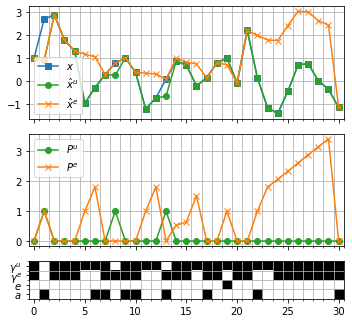

In [7]:
from plot import plot_traj

plot_traj(sensor, user, eavesdropper, e, save_fig=False)

We can run simulations where the sensor employs the threshold-based policy in the same way.

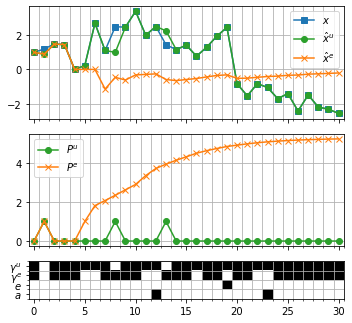

In [8]:
from sensor import ThresholdSensor

thresh = 0.2
sensor = ThresholdSensor(params, thresh, lambda_u, p)

user = Estimator(params)
eavesdropper = Estimator(params)
run_sim(sensor, user, eavesdropper, num_steps, gamma_u, gamma_e, e)
plot_traj(sensor, user, eavesdropper, e, save_fig=False)

Finally, let us discuss solving the optimization problem
$$ \underset{\pi}{\text{max}}\ \varepsilon^e \quad \text{s.t.} \quad \varepsilon^u \leq M $$
by employing a bisection approach. For the random transmission policies, this means finding the lowest probability $\alpha$ of sending the plain state so that $\varepsilon^u \leq M$. For the threshold-based policies, we need to find the biggest threshold $N$ so that $\varepsilon^u \leq M$. We provide functions that conduct the bisection approach automatically. However, depending on the setting, the number of simulation steps they execute in order to approximate $\varepsilon$ might have to be increased.

We demonstrate finding an optimal $\alpha$ for the random transmission policy below. As this can take a few minutes, we cap the number of bisection steps in this notebook. You can adapt the code below to find an optimal threshold instead by using the function ```find_optimal_threshold```.

In [9]:
from solve_optim import find_optimal_alpha, find_optimal_threshold

M = 1
alpha_opt, error_u, error_e = find_optimal_alpha(params, M, lambda_u, lambda_e, p, max_steps=5)
print("optimal alpha: {}".format(alpha_opt))

(low, alpha, up): (0,0.5,1)
1
2
user error: 0.284
eaves error: 0.4939

(low, alpha, up): (0,0.25,0.5)
1
2
user error: 0.4012
eaves error: 1.0379

(low, alpha, up): (0,0.125,0.25)
1
2
user error: 0.7063
eaves error: 1.9638

(low, alpha, up): (0,0.0625,0.125)
1
2
user error: 1.248
eaves error: 3.0225

(low, alpha, up): (0.0625,0.0938,0.125)
1
2
user error: 0.9569
eaves error: 2.3807

(low, alpha, up): (0.0625,0.0781,0.0938)
Reached maximum number of bisection steps.
optimal alpha: 0.078125


Let us check if the $\alpha$ computed above gives approximately correct results.

In [10]:
num_steps = 50000

sensor = RandomSensor(params, alpha_opt)
user = Estimator(params)
eavesdropper = Estimator(params)

gamma_u = np.random.binomial(1, lambda_u, num_steps)
gamma_e = np.random.binomial(1, lambda_e, num_steps)
e = np.random.binomial(1, p, num_steps)

run_sim(sensor, user, eavesdropper, num_steps, gamma_u, gamma_e, e)

print("estimation error user: {}".format(user.mean_error))
print("estimation error eavesdropper: {}".format(eavesdropper.mean_error))

estimation error user: 0.9988482024251903
estimation error eavesdropper: 2.652447596222671
